# Upload files in Google Colab
If you are running this Jupyter Notebook on Google Colab, run this cell to upload the data files (train_inputs.csv, train_targets.csv, test_inputs.csv, test_targets.csv) in the colab virtual machine.  You will be prompted to select files that you would like to upload. 

If you are running this Jupyter Notebook on your computer, you do not need to run this cell.

In [3]:
from google.colab import files
uploaded = files.upload()
%ls

Saving test_inputs.csv to test_inputs.csv
Saving test_labels.csv to test_labels.csv
Saving train_inputs.csv to train_inputs.csv
Saving train_labels.csv to train_labels.csv
sample_data/     test_labels.csv   train_labels.csv
test_inputs.csv  train_inputs.csv


# Import libraries 
Do not use any other Python library.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Function: load_logistic_regression_data

This function loads the data for Logistic Regression from a local drive into RAM

Outputs:

*   **train_inputs**: numpy array of N training data points x M features
*   **train_labels**: numpy array of N training labels
*   **test_inputs**: numpy array of N' test data points x M features
*   **test_labels**: numpy array of N' test labels

In [5]:
def load_logistic_regression_data():
  test_inputs = np.genfromtxt('test_inputs.csv', delimiter=',')
  test_labels = np.genfromtxt('test_labels.csv', delimiter=',')
  train_inputs = np.genfromtxt('train_inputs.csv', delimiter=',')
  train_labels = np.genfromtxt('train_labels.csv', delimiter=',')
  return train_inputs, train_labels, test_inputs, test_labels

# Function: sigmoid

This function implements the logistic sigmoid.

Input:
*   **input**: vector of inputs (numpy array of floats)

Output:
*   **output**: vector of outputs (numpy array of floats)

In [6]:
def sigmoid(input):

  output = 1/(1+np.exp(-input))
  
  return output

# Function: predict_logistic_regression

This function uses a vector of weights to make predictions for a set of inputs.  The prediction for each data point is a distribution over the labels.  Assume that there are only two possible labels {0,1}.

Inputs:
*   **inputs**: matrix of input data points for which we want to make a prediction (numpy array of N data points x M+1 features)
*   **weights**: vector of weights (numpy array of M+1 weights)

Output:
*   **predicted_probabilities**: matrix of predicted probabilities (numpy array of N data points x 2 labels)

In [7]:
def predict_logistic_regression(inputs, weights):
  p = sigmoid (np.matmul(inputs,weights))
  predicted_probabilities = np.array([p,1-p]).T
  return predicted_probabilities
  # check this

# Function eval_logistic_regression

This function evaluates a set of predictions by computing the negative log probabilities of the labels and the accuracy (percentage of correctly predicted labels).  Assume that there are only two possible labels {0,1}.  A data point is correctly labeled when the probability of the target label is >= 0.5.

Inputs:
*   **inputs**: matrix of input data points for which we will evaluate the predictions (numpy array of N data points x M+1 features)
*   **weights**: vector of weights (numpy array of M+1 weights)
*   **labels**: vector of target labels associated with the inputs (numpy array of N labels)

Outputs:
*   **neg_log_prob**: negative log probability of the set of predictions (float)
*   **accuracy**: percentage of correctly labeled data points (float)

In [8]:
def eval_logistic_regression(inputs, weights, labels):
  # epsilon = 1e-50
  predicted_probabilities =predict_logistic_regression(inputs, weights)
  predicted_labels = (np.sign(2*predicted_probabilities[:,0]-1)+1)/2
  accuracy = 1-(np.sum(np.abs(predicted_labels-labels))/inputs.shape[0])
  L1 = labels*np.log(sigmoid (np.matmul(weights,inputs.T))) 
  L2 = (1-labels)*np.log(1-sigmoid (np.matmul(weights,inputs.T)))
  neg_log_prob=-np.sum(L1+L2)
  return neg_log_prob, accuracy

Function: initialize_weights

This function initializes the weights uniformly at random in the interval [-0.05,0.05]

Input:
*   **n_weights**: # of weights to be initialized (integer)

Output:
*   **random_weights**: vector of weights (numpy array of floats)

In [9]:
def initialize_weights(n_weights):

  random_weights =np.random.uniform(low=-0.05, high=0.05, size=n_weights)
  return random_weights

# Function train_logistic_regression

This function optimizes a set of weights for logistic regression based on a training set.  Initialize the weights with the function initialize_weights.  Implement Newton's algorithm to optimize the weights.  Stop Newton's algorithm when the maximum change for all weights is less than 0.001 in two consecutive iterations. Assume that there are only two labels {0,1}.

Inputs:
*   **train_inputs**: matrix of input training points (numpy array of N data points x M+1 features)
*   **train_labels**: vector of labels associated with the inputs (numpy array of N labels)
*   **lambda_hyperparam**: lambda hyperparameter used to adjust the importance of the regularizer (scalar)

Output:
*   **weights**: vector of weights that have been optimized (numpy array of M+1 weights)



In [10]:
def train_logistic_regression(train_inputs, train_labels, lambda_hyperparam):
  weights =initialize_weights(train_inputs.shape[1])
  d_weight_old = 1
  d_weight = 1
  while 1:
    d_weight_old = d_weight
    R1 = sigmoid(np.matmul(weights,train_inputs.T))*(1-sigmoid(np.matmul(weights,train_inputs.T)))
    R=np.diag(R1)
    I = np.diag(np.ones(train_inputs.shape[1]))
    H = np.matmul(np.matmul(train_inputs.T,R),train_inputs)+lambda_hyperparam*I
    s = np.matmul(weights,train_inputs.T)
    s2 = sigmoid (s) - train_labels
    G =  np.sum(np.multiply(s2,train_inputs.T),1)+lambda_hyperparam*weights
    d_weight = -np.matmul(np.linalg.inv(H),G)
    # d_weight = -0.01*G
    weights = weights + d_weight
    if np.linalg.norm(d_weight,1) < 0.001:
      if np.linalg.norm(d_weight_old,1) < 0.001:
        # print(np.linalg.norm(d_weight)) 
        break 
  return weights

# Function cross_validation_logistic_regression

This function performs k-fold cross validation to determine the best lambda hyperparameter in logistic regression

Inputs:
*   **k_folds**: # of folds in cross-validation (integer)
*   **hyperparameters**: list of hyperparameters where each hyperparameter is a different lambda value (list of floats)
*   **inputs**: matrix of input points (numpy array of N data points by M+1 features)
*   **labels**: vector of labels associated with the inputs (numpy array of N labels)

Outputs:
*   **best_hyperparam**: best lambda value for logistic regression (float)
*   **best_neg_log_prob**: negative log probabilty achieved with best_hyperparam (float)
*   **neg_log_probabilities**: vector of negative log probabilities for the corresponding hyperparameters (numpy array of floats)



In [11]:
def cross_validation_logistic_regression(k_folds, hyperparameters, inputs, labels):
  Train=np.concatenate((inputs,inputs),axis=0)
  Label=np.concatenate((labels, labels),axis=0)
  neg_log_probabilities = np.zeros(len(hyperparameters))
  print("Training... |                     |")
  print("             ",end='')
  for j in range(len(hyperparameters)):
    if np.mod(j,10)==0:
      print('*',end='')
    l = hyperparameters[j]
    # print(l)
    fold_neg_log_probabilities = np.zeros(10)
    for i in range(k_folds):
      Val = Train[100*i:100*i+99,:]
      Val_label = Label[100*i:100*i+99]
      train = Train[100*i+100:100*i+999,:]
      label = Label[100*i+100:100*i+999]
      weights = train_logistic_regression(train, label, l)
      ax1 , ax2 = eval_logistic_regression(Val, weights, Val_label)
      fold_neg_log_probabilities[i]=ax1
    neg_log_probabilities[j]=sum(fold_neg_log_probabilities)/10
    # print(neg_log_probabilities[j])
  A = np.argmin(neg_log_probabilities)
  best_hyperparam = hyperparameters[A]
  best_neg_log_prob = np.amin(neg_log_probabilities)
  
  
  return best_hyperparam, best_neg_log_prob, neg_log_probabilities

# Function: plot_logistic_regression_neg_log_probabilities

Function that plots the negative log probabilities for different lambda values (hyperparameters) in logistic regression based on cross validation

Inputs:
*   **neg_log_probabilities**: vector of negative log probabilities for the corresponding hyperparameters (numpy array of floats)
*   **hyperparams**: list of hyperparameters where each hyperparameter is a different lambda value (list of floats)

In [12]:
def plot_logistic_regression_neg_log_probabilities(neg_log_probabilities,hyperparams):
  plt.plot(hyperparams,neg_log_probabilities)
  plt.ylabel('negative log probability')
  plt.xlabel('lambda')
  plt.show()

# Main Logistic Regression code

Load data (rescale the inputs to be in the [-1,1] range, add 1 at the end of each datapoint and rename the labels 5,6 to 0,1).
Use k-fold cross validation to find the best lambda value for logistic regression.
Plot the negative log probabilities for different lambda values.
Test logistic regression with the best lambda value.

Training... |                     |
             *********************

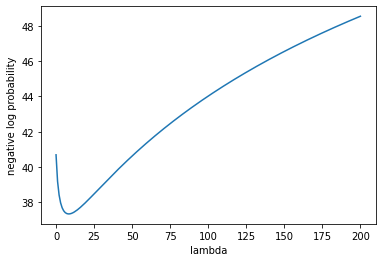

best lambda: 8
best cross validation negative log probability: 37.352306785389615
test accuracy: 0.8727272727272728
test negative log probability: 33.29202902957821


In [13]:
# load data
train_inputs, train_labels, test_inputs, test_labels = load_logistic_regression_data()

# rescale inputs in the [-1,1] range
train_inputs = (train_inputs - 8)/8
test_inputs = (test_inputs - 8)/8

# add 1 at the end of each data point
train_inputs = np.concatenate((train_inputs,np.ones((train_inputs.shape[0],1))),1)
test_inputs = np.concatenate((test_inputs,np.ones((test_inputs.shape[0],1))),1)

# rename the classes 5,6 to 0,1
train_labels = train_labels.astype(int) - 5
test_labels = test_labels.astype(int) - 5

# lambda values to be evaluated by cross validation
hyperparams = range(201)
k_folds = 10
best_lambda, best_neg_log_prob, neg_log_probabilities = cross_validation_logistic_regression(k_folds,hyperparams,train_inputs,train_labels)

# plot results
plot_logistic_regression_neg_log_probabilities(neg_log_probabilities,hyperparams)
print('best lambda: ' + str (best_lambda))
print('best cross validation negative log probability: ' + str(best_neg_log_prob))

# train and evaluate with best lambda
weights = train_logistic_regression(train_inputs,train_labels,best_lambda)
neg_log_prob, accuracy = eval_logistic_regression(test_inputs, weights, test_labels)
print('test accuracy: ' + str(accuracy))
print('test negative log probability: ' + str(neg_log_prob))


In [19]:
weights = train_logistic_regression(train_inputs,train_labels,0)
neg_log_prob, accuracy = eval_logistic_regression(train_inputs, weights, train_labels)
print(accuracy)

0.879


**part 2.1:**

Lets imagine a circle shaped cluster of data which one class is within the 2 cm diameter from the center and the other class data is distributed in the outer area of a circle with radius of 3cm. These data points are abviously seperable with a circle like curve and a KNN classifier with a right number of neighbours can classify this data set. In contrast, logistic regression does not perform well on this data set at all since it only search for a hyper plane (line in this case) as a separator which obviously cannot descriminate the data with %100 percent accuracy. This is an example which shows the expressivity of KNN is more than logistic regression classifier since it can find discriminator dunctions (circle in this case) which is impossible for Logistic Regression classifier to find. Another importamt point is that knn can classify any search space that logistic regression could classify but it could be less accurate depending on the situation of the data.

 The more our data is linearly seperable it is better to choose methods which classify the data linearly like Logistic regression.
Comparing the accuracy of KNN results with Log regression we see that the accuracy for log regression is higher about 10 percent.As explained earler,this is not a good measure to check the expressivity of those classifiers since the data used for knn and log regression are more linear separable than non-linear therefor the log resression classifier performs better about 10 percent.

**part 2.2:** 

It is not linearly separable. If this dataset was linearly separable after the data training and W* calculation we would end up having a hyper
plane equation which can seperate all the data given with the accuracy of 100 percent. Reason being, the W* calculation is the global optimum since the
neg log probability function which we are minimizing over is a convex function.
now that we apply the training on the train set itself we get the result of accuracy of 87.9% which is not 100% this means there are some data points in our set
which are at the wrong side of the hyperplane ergo the whole dataset is not linearly separable. We use the lambda = 0 in this test since we are looking for the highest accuracy of the classification and we areo not testing the data so overfitting is not the issue here.

